In [118]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)  # for reproducibility

from sklearn.datasets import make_swiss_roll

from theano import function

from keras.datasets import mnist
from keras.models import Sequential, Graph
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Layer
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from seya.layers.variational import VariationalDense as VAE
from seya.layers.convolutional import GlobalPooling2D
from seya.utils import apply_model
from seya.sandbox.regularization import ITLRegularizer, ITLextInput
from seya.parzen import ParzenWindows

from agnez import grid2d, embedding2dplot

batch_size = 200
nb_epoch = 100
code_size = 2

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 7
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype("float32").reshape((-1, 784))
X_test = X_test.astype("float32").reshape((-1, 784))
X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_valid = X_train[50000:]
Y_valid = Y_train[50000:]
X_train = X_train[:50000]
Y_train = Y_train[:50000]

X_train shape: (60000, 784)
60000 train samples
10000 test samples


In [133]:
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
rng = RandomStreams()

def swiss_roll(Y, noise=5., rng=rng):
    # inspired by sklearn code
    u = np.zeros_like(Y)
    for i, y in enumerate(Y):
        u[i] = np.random.uniform(low=y/10., high=y/10.+.1, size=1)
    #u = rng.uniform(size=(size[0], 1))
    t = 1.5 * np.pi * (1 + 2 * u)
    x = t * np.cos(t)
    # y = 21 * u2
    z = t * np.sin(t)

    X = np.vstack([x, z]).T
    X += noise * np.random.uniform(size=(u.shape[0], 2))
    return X

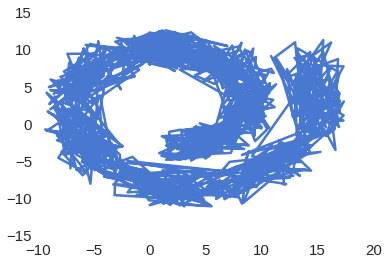

In [134]:
u = np.floor(np.linspace(0, 9, 1000))
z = swiss_roll(u)
plt.plot(z[:, 0], z[:, 1], '-')

In [135]:
model = Graph()
model.add_input('data', input_shape=(784,))
model.add_input('noise', input_shape=(code_size,))

# encoder
model.add_node(Dense(1000, activation='tanh'), name='enc0', input='data')
model.add_node(BN(), name='bn0', input='enc0')
model.add_node(Dense(1000, activation='tanh'), name='enc1', input='bn0')
model.add_node(BN(), name='bn1', input='enc1')
model.add_node(Dense(code_size, activation='linear'), name='enc2', input='bn1')

X = model.get_input()['data']
Y = model.nodes['enc2'].get_output()

# regularizer
model.add_node(ITLextInput(code_size, scale=40., ksize=6.), name='reg',
               inputs=['enc2', 'noise'], merge_mode='concat')

# decoder
model.add_node(Dense(1000, activation='relu'), name='dec0', input='reg')
model.add_node(Dense(784, activation='sigmoid'), name='dec', input='dec0', create_output=True)

model.compile(loss={'dec': 'mse'}, optimizer='adam')

In [136]:
for e in range(nb_epoch):
    loss = 0
    for i in range(50000 / batch_size):
        s = i*batch_size
        f = (i+1)*batch_size
        X_batch = X_train[s:f]
        y_batch = y_train[s:f].astype('float32')
        Z_batch = swiss_roll(y_batch)
        
        loss += model.train_on_batch({'dec': X_batch,
                                      'data': X_batch,
                                      'noise': Z_batch
                                     })[0]
    print("Epoch: {0}/{1} | Loss: {2}".format(e, nb_epoch, loss/(i+1.)))
    

Epoch: 0/100 | Loss: 1.05097080529
Epoch: 1/100 | Loss: 0.152728319615
Epoch: 2/100 | Loss: 0.137759176672
Epoch: 3/100 | Loss: 0.132663870186
Epoch: 4/100 | Loss: 0.128701712221
Epoch: 5/100 | Loss: 0.126326543212
Epoch: 6/100 | Loss: 0.126041697204
Epoch: 7/100 | Loss: 0.123838664234
Epoch: 8/100 | Loss: 0.122939483613
Epoch: 9/100 | Loss: 0.121351118028
Epoch: 10/100 | Loss: 0.118613614947
Epoch: 11/100 | Loss: 0.119144390881
Epoch: 12/100 | Loss: 0.11686768049
Epoch: 13/100 | Loss: 0.115155207008
Epoch: 14/100 | Loss: 0.114900864929
Epoch: 15/100 | Loss: 0.114092830181
Epoch: 16/100 | Loss: 0.113879880369
Epoch: 17/100 | Loss: 0.112521534622
Epoch: 18/100 | Loss: 0.112465790421
Epoch: 19/100 | Loss: 0.10999095276
Epoch: 20/100 | Loss: 0.109483195066
Epoch: 21/100 | Loss: 0.109474302739
Epoch: 22/100 | Loss: 0.110137034982
Epoch: 23/100 | Loss: 0.108084327281
Epoch: 24/100 | Loss: 0.108103250146
Epoch: 25/100 | Loss: 0.106769018114
Epoch: 26/100 | Loss: 0.10528239885
Epoch: 27/100 |

# Load best model

In [137]:
#model.load_weights('itl.hdf5')

# Sample (for visualization purposes)

In [138]:
y_batch = y_train[s:f]
idx = np.argsort(y_batch)

X_batch = X_train[s:f][idx]
y_batch = y_batch[idx]
Z_batch = swiss_roll(y_batch)

t = model.predict({'data': X_batch, 'noise': Z_batch})['dec']

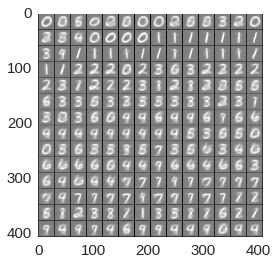

In [139]:
I = grid2d(t)
plt.imshow(I, cmap='gray')

In [140]:
d1 = [model.params[-4].get_value(), model.params[-3].get_value()]
d2 = [model.params[-2].get_value(), model.params[-1].get_value()]

dec = Sequential()
#dec.add(model.nodes['dec0'])
#dec.add(model.nodes['dec'])
dec.add(Dense(1000, input_dim=2, activation='relu', weights=d1))
dec.add(Dense(784, activation='sigmoid', weights=d2))

print(dec.output_shape)

Di = K.placeholder(ndim=2)
D0 = dec(Di)
F = function([Di], D0, allow_input_downcast=True)

(None, 784)


(100, 784)


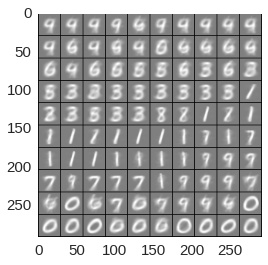

In [141]:
y = F(z[:1000:10])
print(y.shape)
I = grid2d(y.reshape((100, -1)))
plt.imshow(I, cmap='gray')

# Visualize projection

In [142]:
G = function([X], Y, allow_input_downcast=True)

In [ ]:
y = G(X_train[:6000])

In [ ]:
_ = embedding2dplot(y, y_train[:6000], show_median=False)
plt.legend()